**Inception V3 pretrained model for recognition of events from images**

This code is adapted from "Flower17" classification project available at : https://github.com/bouwkast/Flower-CNN

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D


# Create the base pre-trained model
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
base_model = InceptionV3(weights='imagenet', include_top=False)
batch_size = 32  # batch size is chosen to help keep GPU memory usage low
dim = 299  # InceptionV3 is trained on 299x299 images

W0809 10:35:09.839377 140060236105600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 10:35:09.892354 140060236105600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 10:35:09.900448 140060236105600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 10:35:09.938286 140060236105600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0809 10:35:09.939858 1400602361

87916544/87910968 [==============================] - 7s 0us/step


In [0]:
num_training_img = 1470  # number of training images for dataset
num_val_img = 350  # number of validation images for dataset
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

In [0]:
# Select number of events to train on
predictions = Dense(7, activation='softmax')(x)
# predictions = Dense(17, activation='softmax')(x)

In [0]:
# This is the model we will train
model = Model(input=base_model.input, output=predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [0]:
# First: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [0]:
# Compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

W0809 10:36:40.964383 140060236105600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# preprocessor for the training training data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,  # regularize RGB color values to floats between 0.0 to 1.0
    horizontal_flip=True,
    fill_mode='constant')  # in case resizing needs to create new image - fill it in with black


In [0]:
# preprocessor for the testing data
# only rescaling for regularization
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/widerdata/images')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# generator for creating batch_size of training images with all transformations applied
# leaves us with more images than we start with
train_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/widerdata/images',  # this is the target directory
    target_size=(dim, dim),  # all images will be resized to dim * dim
    batch_size=batch_size,
    class_mode='categorical')

Found 1470 images belonging to 7 classes.


In [0]:
# generator for creating batch_size of validation images with only regularization and resizing
# leaves us with the same amount of images that we start with
validation_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/Validation/images',
    target_size=(dim, dim),
    batch_size=batch_size,
    class_mode='categorical')

Found 350 images belonging to 7 classes.


In [0]:
print(validation_generator.class_indices)

{'0 Parade': 0, '1 Handshaking': 1, '2 Demonstration': 2, '3 Riot': 3, '4 Cheering': 4, '5 Shoppers': 5, '6 Soccer': 6}


In [0]:
# all InceptionV3 layers are frozen, we train our added layers, where the weights were randomly initialized
model.fit_generator(
    train_generator,
    steps_per_epoch=num_training_img // batch_size,  # steps =  num_images // batch_size = total num of complete passes
    epochs=10,
    validation_data=validation_generator,
    validation_steps=num_val_img // batch_size)

W0809 10:39:21.234809 140060236105600 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
45/45 [==============================] - 945s 21s/step - loss: 3.4793 - acc: 0.3049 - val_loss: 2.2891 - val_acc: 0.3125
Epoch 2/10
45/45 [==============================] - 34s 763ms/step - loss: 1.6306 - acc: 0.4337 - val_loss: 1.0340 - val_acc: 0.6258
Epoch 3/10
45/45 [==============================] - 18s 400ms/step - loss: 1.4280 - acc: 0.4894 - val_loss: 1.3066 - val_acc: 0.6038
Epoch 4/10
45/45 [==============================] - 18s 399ms/step - loss: 1.2473 - acc: 0.5752 - val_loss: 1.5548 - val_acc: 0.5252
Epoch 5/10
45/45 [==============================] - 18s 398ms/step - loss: 1.1589 - acc: 0.5832 - val_loss: 1.4947 - val_acc: 0.5063
Epoch 6/10
45/45 [==============================] - 18s 397ms/step - loss: 1.1204 - acc: 0.5919 - val_loss: 1.1042 - val_acc: 0.6352
Epoch 7/10
45/45 [==============================] - 18s 398ms/step - loss: 1.0403 - acc: 0.6194 - val_loss: 1.5027 - val_acc: 0.5566
Epoch 8/10
45/45 [==============================] - 18s 397ms/step - l

In [0]:
# At this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# Let's visualize layer names and layer indices to see how many layers we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [0]:
# We chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest. This prevents overfitting.
for layer in model.layers[:172]:
    layer.trainable = False
for layer in model.layers[172:]:
    layer.trainable = True

In [0]:
# We need to recompile the model for these modifications to take effect
# We use SGD with a low learning rate
from keras.optimizers import SGD

In [0]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# train our model while back propagating through our layers and the top two blocks of the InceptionV3 architecture
model.fit_generator(
    train_generator,
    steps_per_epoch=num_training_img // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=num_val_img // batch_size,
    callbacks=[EarlyStopping(patience=50), ModelCheckpoint('7_modelInceptionV31.h5', verbose=1, save_best_only=True)])

Epoch 1/100
45/45 [==============================] - 41s 906ms/step - loss: 0.6757 - acc: 0.7567 - val_loss: 0.9456 - val_acc: 0.6572

Epoch 00001: val_loss improved from inf to 0.94556, saving model to 7_modelInceptionV31.h5
Epoch 2/100
45/45 [==============================] - 30s 657ms/step - loss: 0.5632 - acc: 0.8118 - val_loss: 0.9487 - val_acc: 0.6687

Epoch 00002: val_loss did not improve from 0.94556
Epoch 3/100
45/45 [==============================] - 29s 650ms/step - loss: 0.4878 - acc: 0.8475 - val_loss: 0.8705 - val_acc: 0.6918

Epoch 00003: val_loss improved from 0.94556 to 0.87050, saving model to 7_modelInceptionV31.h5
Epoch 4/100
45/45 [==============================] - 29s 651ms/step - loss: 0.4668 - acc: 0.8644 - val_loss: 0.9238 - val_acc: 0.7107

Epoch 00004: val_loss did not improve from 0.87050
Epoch 5/100
45/45 [==============================] - 29s 652ms/step - loss: 0.4257 - acc: 0.8733 - val_loss: 0.9089 - val_acc: 0.6730

Epoch 00005: val_loss did not improve

Testing process

In [0]:
test_generator = ImageDataGenerator(rescale=1. / 255)
test_data_generator = test_generator.flow_from_directory(
    '/content/drive/My Drive/prediction2/images',
    target_size=(dim, dim),
    batch_size=batch_size,
    shuffle=False)
import numpy 
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)


Found 140 images belonging to 7 classes.


In [0]:
predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)

In [0]:
predicted_classes = numpy.argmax(predictions, axis=1)
print(len(predicted_classes))

140


In [0]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_classes]

In [0]:
predicted_classes

array([0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 2, 2, 2,
       2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 5, 3, 3, 3, 2, 3, 2,
       3, 3, 3, 2, 3, 3, 2, 4, 3, 3, 3, 3, 3, 3, 4, 4, 1, 0, 4, 4, 4, 4,
       4, 4, 0, 4, 4, 0, 2, 4, 1, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5,
       2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 0, 6, 6])

In [0]:
class_labels

['0 Parade',
 '1 Handshaking',
 '2 Demonstration',
 '3 Riot',
 '4 Cheering',
 '5 Shoppers',
 '6 Soccer']

In [0]:
import sklearn.metrics as metrics

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                 precision    recall  f1-score   support

       0 Parade       0.77      0.85      0.81        20
  1 Handshaking       0.86      0.95      0.90        20
2 Demonstration       0.62      0.75      0.68        20
         3 Riot       0.88      0.75      0.81        20
     4 Cheering       0.88      0.70      0.78        20
     5 Shoppers       0.86      0.90      0.88        20
       6 Soccer       1.00      0.90      0.95        20

       accuracy                           0.83       140
      macro avg       0.84      0.83      0.83       140
   weighted avg       0.84      0.83      0.83       140



[INFO] confusion matrix


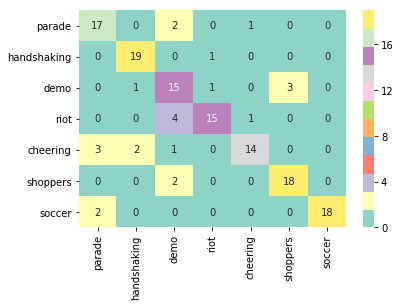

In [0]:
# display the confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

print ("[INFO] confusion matrix")

# get the list of training lables
#labels = sorted(list(os.listdir(test_path)))

# plot the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
cm_df = pd.DataFrame(cm,
                     index = ['parade','handshaking','demo','riot','cheering','shoppers','soccer'], 
                     columns = ['parade','handshaking','demo','riot','cheering','shoppers','soccer'])
sns.heatmap(cm_df,
            annot=True,
            cmap="Set3")

plt.show()